# Geometric Tensor Learning
---

In [21]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
import networkx as nx

import project_path

from util.srpg import srpg_nnfold_modified as nnfold
from util.srpg import gmlsvd
from util.t2m import t2m
from util.m2t import m2t
from util.hosvd import hosvd
from util.geoTL import geoTL
from util.geoTL import initialize_nograd
from util.update_Sigma import fn_val as fnval_Sigma
from util.generate_data import generate_smooth_stationary_data
from util.contaminate_data import contaminate_signal
from util.fn_vals import fn_val_L
from util.fn_vals import fn_val_G

In [22]:
sizes = (10,10,10,10)
ranks = (8,3,3,3)
n = len(sizes)

## Generate Graphs
In this part, we create Erdos-Renyi graphs for each mode.

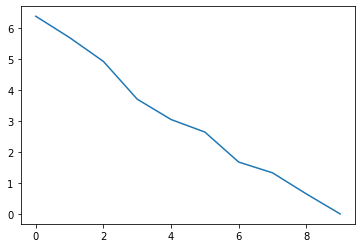

In [23]:
d = 1.1
G = [nx.erdos_renyi_graph(sizes[i], d*np.log(sizes[i])/sizes[i]) for i in range(n)] # List of graphs for each mode
Phi = [nx.laplacian_matrix(G[i]).todense() for i in range(n)] # Graph Laplacians of these graphs
U, S, V = np.linalg.svd(Phi[0])
ind = np.argsort(S)[::-1]
plt.plot(S[ind])

## Data Generation Methods

In this part, we try to generate data smooth and stationary on the product graph.

In [24]:
## Generate data by multiplying the eigenvectors of the Graph Laplacian
# with i.i.d. Gaussian noise with variance given by the eigenvalues of the Laplacian.

X_smooth, V = generate_smooth_stationary_data(Phi)


Let's see how stationarity looks like.

In [25]:
for i in range(n):
    P_X = V[i].transpose()@t2m(X_smooth,i)
    psd = P_X@P_X.transpose()
    # plt.imshow(np.log10(abs(psd)))
    # plt.colorbar()
    # plt.show()

## The Algorithm

In below, we add noise to data and run our algorithm to recover the original signal back.

In [26]:
# Contaminate data.
Y = contaminate_signal(X_smooth, noise_rate=0.2, noise_type='gross')


In [32]:
norm(X_smooth-Y.data)/norm(X_smooth)

1.7660842647750032

In [57]:
ranks = [5,5,5,5]
X, obj_val, lam_val = nnfold(
                    Y, Phi,
                    alpha=np.tile(1/np.sqrt(np.max(sizes)), n),
                    beta=np.tile(0.5/np.sqrt(np.max(sizes)), n),
                    max_iter=500)

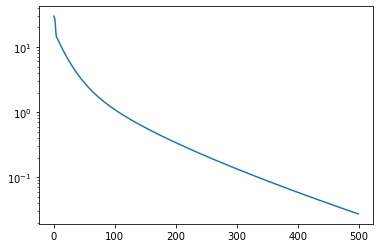

In [58]:
plt.semilogy(lam_val)

In [59]:
norm(X_smooth-X)/norm(X_smooth)

0.8213766771228544

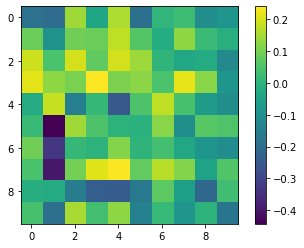

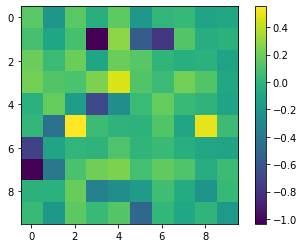

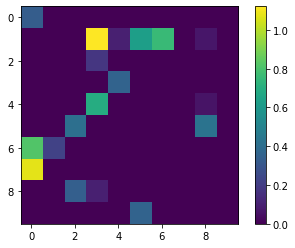

In [17]:
plt.imshow(X_smooth[:,:,0,0])
plt.colorbar()
plt.show()
plt.imshow(Y.data[:,:,0,0])
plt.colorbar()
plt.show()
plt.imshow(abs(Y.data[:,:,0,0]-X_smooth[:,:,0,0]))
plt.colorbar()
plt.show()

In [20]:
norm(X_smooth-X)/norm(X_smooth)

0.8743385302418831

In [ ]:
for i in range(n):
    print('smoothness of the original data: {:.2f}'.format(np.trace(t2m(X_smooth,i).transpose()@Phi[i]@t2m(X_smooth,i))))
    print('smoothness of the noisy data: {:.2f}'.format(np.trace(t2m(Y.data,i).transpose()@Phi[i]@t2m(Y.data,i))))
    print('smoothness of the output: {:.2f}'.format(np.trace(t2m(X,i).transpose()@Phi[i]@t2m(X,i))))

smoothness of the original data: 117.44
smoothness of the noisy data: 135.94
smoothness of the output: 18.42
smoothness of the original data: 54.90
smoothness of the noisy data: 62.67
smoothness of the output: 6.78
smoothness of the original data: 51.26
smoothness of the noisy data: 56.85
smoothness of the output: 7.31
smoothness of the original data: 38.42
smoothness of the noisy data: 45.36
smoothness of the output: 6.29


In [ ]:
for i in range(n):
    P_Y = V[i].transpose()@t2m(Y.data,i)
    cov = t2m(Y.data,i)@t2m(Y.data,i).transpose()
    psd_y = np.array(P_Y@P_Y.transpose())
    psd_off_diag = norm(psd_y.ravel(), ord=1) - np.trace(psd_y)
    cov_off_diag = norm(cov.ravel(), ord=1) - np.trace(cov)
    print(cov_off_diag/psd_off_diag)
    print(np.trace(Phi[i]))
    print('Ratio of degrees to off diagonal mismatch is: {}'.format(np.trace(Phi[i])/(cov_off_diag/psd_off_diag)))

1.7998241146084473
82
Ratio of degrees to off diagonal mismatch is: 45.560007410968126
1.7071110699863872
16
Ratio of degrees to off diagonal mismatch is: 9.372559455154601
3.599786637504117
12
Ratio of degrees to off diagonal mismatch is: 3.333530902909319
0.6378334910379986
10
Ratio of degrees to off diagonal mismatch is: 15.678072946163711


In [ ]:
L, G_var, Lx, X, Sigma, Lambda, gamma, theta, alpha = initialize_nograd(sizes)

In [ ]:
for i in range(n):
    x_smooth_val = np.trace(t2m(Y.data,i).transpose()@Phi[i]@t2m(Y.data,i))
    y_smooth_val = np.trace(t2m(X_smooth,i).transpose()@Phi[i]@t2m(X_smooth,i))
    print('Ratio is (Y/X): {:.6f}'.format(x_smooth_val/y_smooth_val))

Ratio is (Y/X): 2.183965
Ratio is (Y/X): 1.999965
Ratio is (Y/X): 2.058381
Ratio is (Y/X): 2.367439


In [ ]:

Y_rep = [Y.data for i in range(n)]
gamma = [gamma[i] for i in range(n)]
theta = [theta[i] for i in range(n)]
y_sigma = [t2m(Y.data,i)@t2m(Y.data,i).transpose() for i in range(n)]
y_smooth_val = fn_val_G(Y_rep, Y.data, Phi, Lambda[0], alpha[0], gamma)[1]
comm_y = fnval_Sigma(y_sigma, Lx, X, Phi, Lambda[3], alpha[3], theta)[1]
var_y = np.var(Y.data)
for i in range(n):
    gamma[i] = var_y*sizes[i]**2/(25*d**2)
    theta[i] = sizes[i]**4/(d**4*10**7)
    print('The smoothness value for Y at mode {} is: {:.4f}'.format(i,y_smooth_val[i])
    )
    print('The commutativity value for Y at mode {} is: {:.4f}'.format(i,comm_y[i])
    )



The smoothness value for Y at mode 0 is: 0.0595
The commutativity value for Y at mode 0 is: 0.0107
The smoothness value for Y at mode 1 is: 0.0413
The commutativity value for Y at mode 1 is: 0.0012
The smoothness value for Y at mode 2 is: 0.0267
The commutativity value for Y at mode 2 is: 0.0006
The smoothness value for Y at mode 3 is: 0.0231
The commutativity value for Y at mode 3 is: 0.0005


In [ ]:
# Function value for noisy Y
err_orig = fn_val_L(Y.data, Y, Lx, G_var, Lambda[:2], alpha[:2])[1]

# print('Error value of noisy signal: {:.1e}'.format(err_orig))
# print('Smoothness value of noisy signal: {:.1e}'.format(sum(y_smooth_val)))
# print('Commutivity value of noisy signal: {:.1e}'.format(sum(comm_y)))

In [ ]:
# Function value for original X
X_rep = [X_smooth for i in range(n)]
err_orig = fn_val_L(X_smooth, Y, Lx, G_var, Lambda[:2], alpha[:2])[1]
smooth_orig = fn_val_G(X_rep, X_smooth, Phi, Lambda[0], alpha[0], gamma)[1]
x_sigma = [t2m(X_smooth,i)@t2m(X_smooth,i).transpose() for i in range(n)]
comm_orig = fnval_Sigma(x_sigma, Lx, X, Phi, Lambda[3], alpha[3], theta)[1]

# print('Error value of original signal: {:.1e}'.format(err_orig))
# print('Smoothness value of original signal: {:.1e}'.format(sum(smooth_orig)))
# print('Commutivity value of original signal: {:.1e}'.format(sum(comm_orig)))

In [ ]:
L, fval_tot, lam_val = geoTL(Y, Phi, gamma, theta, alpha, max_iter=500, err_tol=1e-2,verbose=True)

Objective function changes for L: -2.94e+01, G: -4.49e-02, Lx: -4.18e+00, X: -2.05e+00, Sigma: -2.99e+01
Total Objective Function Value at iter 0: 5.663e+00
Objective function changes for L: -1.69e-04, G: -4.83e-03, Lx: -4.81e+00, X: -1.79e+00, Sigma: -1.70e-01
Total Objective Function Value at iter 1: 5.660e+00
Objective function changes for L: -7.40e-01, G: -6.51e-03, Lx: -1.11e+00, X: -9.50e-01, Sigma: -1.34e-01
Total Objective Function Value at iter 2: 3.128e+00
Objective function changes for L: -3.02e-01, G: -5.99e-03, Lx: -3.46e-01, X: -2.60e-01, Sigma: -5.47e-02
Total Objective Function Value at iter 3: 2.259e+00
Objective function changes for L: -2.01e-01, G: -5.77e-03, Lx: -3.79e-02, X: -3.07e-02, Sigma: -7.93e-03
Total Objective Function Value at iter 4: 2.558e+00
Objective function changes for L: -5.82e-02, G: -5.12e-03, Lx: -2.58e-03, X: -1.86e-03, Sigma: -5.71e-04
Total Objective Function Value at iter 5: 3.587e+00
Objective function changes for L: -7.90e-03, G: -4.40e-03,

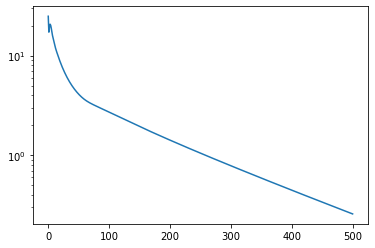

In [ ]:
plt.semilogy(lam_val)

## Examine Results
Let's see how our algorithm performed. Starting with normalized error from the original signal.

In [ ]:
print('Normalized error of the output: {:.2f}'.format(norm(X_smooth-L)/norm(X_smooth)))
print('Normalized error of the input: {:.2f}'.format(norm(X_smooth-Y)/norm(X_smooth)))


Normalized error of the output: 0.74
Normalized error of the input: 0.91


In [ ]:
for i in range(n):
    x_smooth_val = np.trace(t2m(X_smooth,i).transpose()@Phi[i]@t2m(X_smooth,i))
    l_smooth_val = np.trace(t2m(L,i).transpose()@Phi[i]@t2m(L,i))
    print('The smoothness value for X is: {:.2f}, while for L it is: {:.2f}'.format(
        x_smooth_val,
        l_smooth_val
        )
    )
    print('Ratio is (X/L): {:.6f}'.format(x_smooth_val/l_smooth_val))

The smoothness value for X is: 86.17, while for L it is: 107.34
Ratio is (X/L): 0.802799
The smoothness value for X is: 65.25, while for L it is: 84.43
Ratio is (X/L): 0.772899
The smoothness value for X is: 40.95, while for L it is: 54.60
Ratio is (X/L): 0.749958
The smoothness value for X is: 30.85, while for L it is: 46.97
Ratio is (X/L): 0.656819


In [ ]:
for i in range(n):
    x_smooth_val = np.trace(t2m(Y.data,i).transpose()@Phi[i]@t2m(Y.data,i))
    l_smooth_val = np.trace(t2m(L,i).transpose()@Phi[i]@t2m(L,i))
    print('The smoothness value for Y is: {:.4e}, while for L it is: {:.4e}'.format(
        x_smooth_val,
        l_smooth_val
        )
    )
    print('Ratio is (Y/L): {:.6f}'.format(x_smooth_val/l_smooth_val))

The smoothness value for Y is: 1.8820e+02, while for L it is: 1.0734e+02
Ratio is (Y/L): 1.753285
The smoothness value for Y is: 1.3050e+02, while for L it is: 8.4427e+01
Ratio is (Y/L): 1.545772
The smoothness value for Y is: 8.4287e+01, while for L it is: 5.4601e+01
Ratio is (Y/L): 1.543699
The smoothness value for Y is: 7.3033e+01, while for L it is: 4.6967e+01
Ratio is (Y/L): 1.554979


In [ ]:
# Plot stationarity for Y
for i in range(n):
    P_Y = V[i].transpose()@t2m(Y.data,i)
    cov = t2m(Y.data,i)@t2m(Y.data,i).transpose()
    psd_y = np.array(P_Y@P_Y.transpose())
    psd_off_diag = norm(psd_y.ravel(), ord=1) - np.trace(psd_y)
    print(psd_off_diag)
    cov_off_diag = norm(cov.ravel(), ord=1) - np.trace(cov)
    print(cov_off_diag)
    print(cov_off_diag/psd_off_diag)
    print(np.trace(Phi[i]))
    # plt.imshow(np.log10(abs(psd_y)))
    # plt.colorbar()
    # plt.show()

37.42193368325348
67.35289865839772
1.7998241146084473
82
9.435912520923985
16.108150719892492
1.7071110699863872
16
7.075068022325588
25.46873532620033
3.599786637504117
12
19.427293234685663
12.39137826529845
0.6378334910379986
10


In [ ]:
# # Plot stationarity for L
# for i in range(n):
#     P_L = V[i].transpose()@t2m(L,i)
#     cov = P_L@P_L.transpose()
#     plt.imshow(np.log10(abs(cov)))
#     plt.colorbar()
#     plt.show()

In [ ]:
# plt.semilogy(fval_tot[7:]-min(fval_tot[7:]))
# plt.show()

In [ ]:
# Function value for original X
X_rep = [X_smooth for i in range(n)]
err_orig = fn_val_L(X_smooth, Y, Lx, G_var, Lambda[:2], alpha[:2])[1]
smooth_orig = fn_val_G(X_rep, X_smooth, Phi, Lambda[0], alpha[0], gamma)[1]
x_sigma = [t2m(X_smooth,i)@t2m(X_smooth,i).transpose() for i in range(n)]
comm_orig = fnval_Sigma(x_sigma, Lx, X, Phi, Lambda[3], alpha[3], theta)[1]

orig_fn_val = sum(err_orig + smooth_orig + comm_orig)
print('Function value of original signal: {:.1e}'.format(orig_fn_val))

Function value of original signal: 7.8e+01


In [ ]:
# Function value for learned L
L_rep = [L for i in range(n)]
err_l = fn_val_L(L, Y, Lx, G_var, Lambda[:2], alpha[:2])[1]
smooth_l = fn_val_G(L_rep, L, Phi, Lambda[0], alpha[0], gamma)[1]
l_sigma = [t2m(L,i)@t2m(L,i).transpose() for i in range(n)]
comm_l = fnval_Sigma(l_sigma, Lx, X, Phi, Lambda[3], alpha[3], theta)[1]

l_fn_val = sum(err_l + smooth_l + comm_l)
print('Function value of the output signal: {:.1e}'.format(l_fn_val))

Function value of the output signal: 1.4e+01


In [ ]:
print(err_orig)
print(err_l)

18.262814314062922
1.8565160491866954


In [ ]:
print(sum(smooth_orig))
print(sum(smooth_l))

5.027553023943694
6.346700582559795


In [ ]:
print(sum(comm_orig))
print(sum(comm_l))

0.051599458475432965
0.039576331490876034


In [ ]:
# Ymat = t2m(Y.data, 0)
# cov = Ymat@Ymat.transpose()

# fig, ax = plt.subplots(figsize = (15,15))
# im = ax.imshow(cov)

# for i in range(cov.shape[0]):
#     for j in range(cov.shape[1]):
#         text = ax.text(j, i, np.round(np.log10(cov[i, j]), 2) ,
#                        ha="center", va="center", color="w")

In [ ]:
import project_path
from util.syn_exps import grid_search
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class param():
    def __init__(self, size_list, d_list):
        self.d_list = d_list
        self.size_list = size_list

In [ ]:
n_levels = np.arange(-5,20)
d_levels = [1.3]
sizes = [(10,10,10,10)]
params = param(sizes, d_levels)
stat_vals, comm_vals = grid_search(n_levels, params)

<StemContainer object of 3 artists>

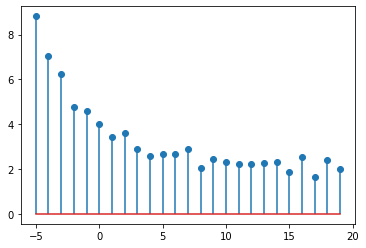

In [ ]:
plt.stem(n_levels, np.sum(stat_vals, 3).squeeze())

<StemContainer object of 3 artists>

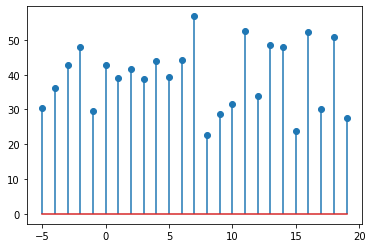

In [ ]:
plt.stem(n_levels, np.sum(comm_vals, 3).squeeze())

<StemContainer object of 3 artists>

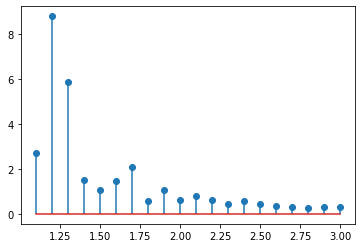

In [ ]:
plt.stem(d_levels, np.sum(stat_vals, 3).squeeze())

<StemContainer object of 3 artists>

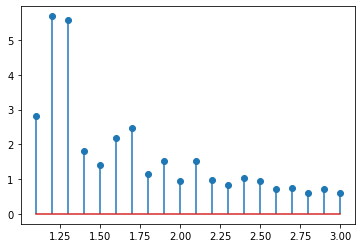

In [ ]:
plt.stem(d_levels, np.sqrt(np.sqrt(np.sum(comm_vals, 3).squeeze())))

<StemContainer object of 3 artists>

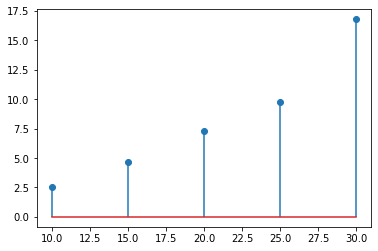

In [ ]:
plt.stem([10,15,20,25,30], np.sqrt(np.sum(stat_vals, 3).squeeze()))

<StemContainer object of 3 artists>

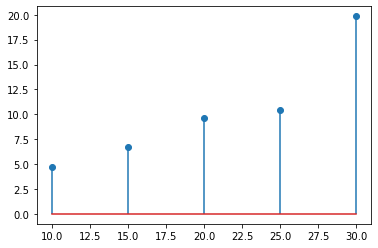

In [ ]:
plt.stem([10,15,20,25,30], np.sqrt(np.sqrt(np.sum(comm_vals, 3).squeeze())))